In [1]:
import numpy as np
import tools

Nscale_points = 7
Nscale_map = np.linspace(0, 3, Nscale_points)

ZA_points = 7
airmass_map = np.linspace(1, tools.calc_air_mass(75), ZA_points)
# ZA_map scaling with linear air_mass
ZA_map = tools.calc_zenith(airmass_map)

freq_points = 240001
Tb_scalar_field = np.zeros((Nscale_points, ZA_points, freq_points))
Nscale_jacobian = np.zeros((Nscale_points, ZA_points, freq_points))
airmass_jacobian = np.zeros((Nscale_points, ZA_points, freq_points))

# Load interpolation & jacobian data
for idx, Nscale in enumerate(Nscale_map):
    for jdx, airmass in enumerate(airmass_map):

        filename = f'MaunaKea_Tb_Spectrum_{airmass:.1f}_{Nscale:.1f}'
        data = np.load(f'{filename}.out')

        freq_map = data[:,0]
        
        # Second column is Tb in K
        Tb_scalar_field[idx,jdx] = data[:,2]

        # Jacobian
        conversation_factor = 2109.86 * 10**-3
        Nscale_jacobian[idx,jdx] = (data[:,4] / conversation_factor)

        ZA = tools.calc_zenith(airmass)     # Deg
        airmass_jacobian[idx,jdx] = (data[:,3]) * ( np.sin(np.radians(ZA)) / ((np.cos(np.radians(ZA)))**2) )


In [2]:
def DD_CubicHermiteSpline(airmass_map, Nscale_map, Tb_scalar_field, 
                          airmass_jacobian, Nscale_jacobian,
                          eval_airmass, eval_nscale, freq_map,
                          reverse=False):

    from scipy.interpolate import CubicHermiteSpline
    from scipy.interpolate import RegularGridInterpolator

    if reverse:
        # Interpolate for chosen nscale
        interp_func = CubicHermiteSpline(
            x=Nscale_map, y=Tb_scalar_field, dydx=Nscale_jacobian, axis=0
        )

        Nscale_eval_grid = interp_func(eval_nscale)
        
        # Interpolate for airmass Jacobian at the chosen nscale value
        interp_func = RegularGridInterpolator(
            points=(Nscale_map, airmass_map, freq_map), values=airmass_jacobian, method="linear"
        )
        
        x,y,z = np.meshgrid(eval_nscale, airmass_map, freq_map, indexing='ij')
        airmass_jacobian_fixed_nscale = interp_func(
            (x.flatten(),y.flatten(),z.flatten())
        ).reshape(Nscale_eval_grid.shape)

        # Interpolate for 2D spectrum using chosen airmass and fixed airmass Jacobian
        interp_func = CubicHermiteSpline(
            x=airmass_map, y=Nscale_eval_grid, dydx=airmass_jacobian_fixed_nscale, axis=0
        )
        interp_val = interp_func(eval_airmass).reshape(freq_map.shape)
        
        return interp_val
    else:
        # Interpolate for chosen airmass
        interp_func = CubicHermiteSpline(
            x=airmass_map, y=Tb_scalar_field, dydx=airmass_jacobian, axis=1
        )

        airmass_eval_grid = interp_func(eval_airmass)
        
        # Interpolate for nscale Jacobian at the chosen airmass
        interp_func = RegularGridInterpolator(
            points=(Nscale_map, airmass_map, freq_map), values=Nscale_jacobian, method="linear"
        )
        
        x,y,z = np.meshgrid(Nscale_map, eval_airmass, freq_map, indexing='ij')
        nscale_jacobian_fixed_airmass = interp_func(
            (x.flatten(),y.flatten(),z.flatten())
        ).reshape(airmass_eval_grid.shape)

        # Interpolate for 2D spectrum using chosen nscale and fixed nscale Jacobian
        interp_func = CubicHermiteSpline(
            x=Nscale_map, y=airmass_eval_grid, dydx=nscale_jacobian_fixed_airmass, axis=0
        )
        interp_val = interp_func(eval_nscale).reshape(freq_map.shape)
        
        return interp_val


In [8]:
eval_grid = np.zeros_like(Tb_scalar_field)
for idx, Nscale in enumerate(Nscale_map):
    for jdx, airmass in enumerate(airmass_map):
        eval_grid[idx,jdx] = DD_CubicHermiteSpline(
            airmass_map=airmass_map[::2], Nscale_map=Nscale_map[::2], Tb_scalar_field=Tb_scalar_field[::2,::2],
            airmass_jacobian=airmass_jacobian[::2,::2], Nscale_jacobian=Nscale_jacobian[::2,::2],
            freq_map=freq_map, eval_airmass=airmass, eval_nscale=Nscale, reverse=True
        )
comparison_grid = ((eval_grid - Tb_scalar_field) / Tb_scalar_field) * 100

Text(0.5, 1.0, 'Midpoint Comparison')

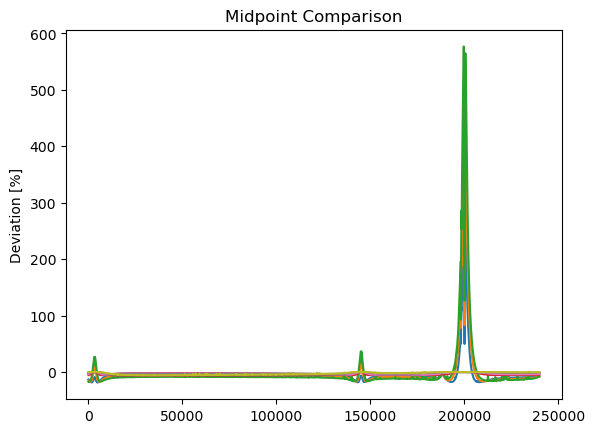

In [9]:
import matplotlib.pyplot as plt

for idx in range(1, Nscale_points, 2):
    for jdx in range(1, ZA_points, 2):
        plt.plot(comparison_grid[idx,jdx])

#names = ['NSCALE', 'Elevation', 'Frequency']
#plt.legend(names, loc=(1.01, 0.82))
plt.ylabel("Deviation [%]")
plt.title("Midpoint Comparison")

Text(0.5, 1.0, 'Verify Even Points')

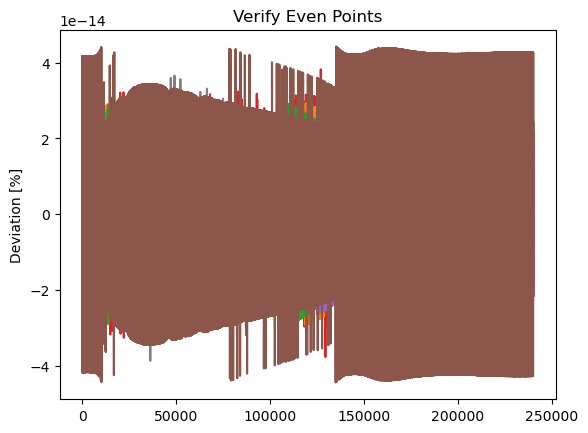

In [10]:
for idx in range(0, Nscale_points, 2):
    for jdx in range(0, ZA_points, 2):
        plt.plot(comparison_grid[idx,jdx])

#names = ['NSCALE', 'Elevation', 'Frequency']
#plt.legend(names, loc=(1.01, 0.82))
plt.ylabel("Deviation [%]")
plt.title("Verify Even Points")

In [6]:
eval_grid_true = np.zeros_like(Tb_scalar_field)
for idx, Nscale in enumerate(Nscale_map):
    for jdx, airmass in enumerate(airmass_map):
        eval_grid[idx,jdx] = DD_CubicHermiteSpline(
            airmass_map=airmass_map, Nscale_map=Nscale_map, Tb_scalar_field=Tb_scalar_field,
            airmass_jacobian=airmass_jacobian, Nscale_jacobian=Nscale_jacobian,
            freq_map=freq_map, eval_airmass=airmass, eval_nscale=Nscale, reverse=True
        )

comparison_grid_true = ((eval_grid_true - Tb_scalar_field) / Tb_scalar_field) * 100

eval_grid_false = np.zeros_like(Tb_scalar_field)
for idx, Nscale in enumerate(Nscale_map):
    for jdx, airmass in enumerate(airmass_map):
        eval_grid[idx,jdx] = DD_CubicHermiteSpline(
            airmass_map=airmass_map, Nscale_map=Nscale_map, Tb_scalar_field=Tb_scalar_field,
            airmass_jacobian=airmass_jacobian, Nscale_jacobian=Nscale_jacobian,
            freq_map=freq_map, eval_airmass=airmass, eval_nscale=Nscale, reverse=True
        )

comparison_grid_false = ((eval_grid_true - Tb_scalar_field) / Tb_scalar_field) * 100

comparison_grid_true_false = comparison_grid_false - comparison_grid_false

Text(0.5, 1.0, 'Compare Interpolation Order of Operation')

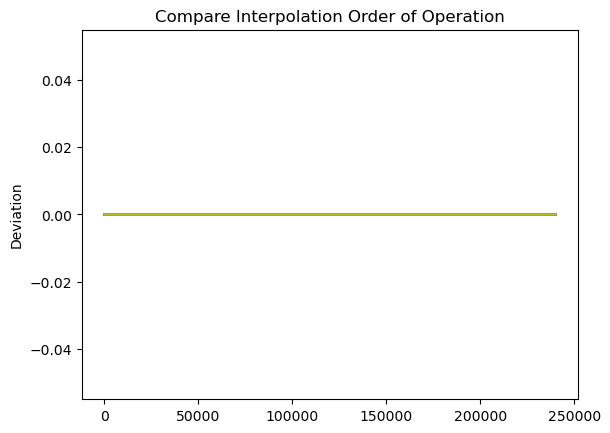

In [61]:
for idx in range(0, Nscale_points):
    for jdx in range(0, ZA_points):
        plt.plot(comparison_grid_true_false[idx,jdx])

plt.ylabel("Deviation")
plt.title("Compare Interpolation Order of Operation")